<a href="https://www.kaggle.com/code/sidakou/forest-of-four-xgb-lgb-cat-rf-ensemble?scriptVersionId=272562562" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Forest of Four: XGB, LGB, CAT, RF Ensemble 🌳🌲🌴🌵

This notebook explores an **ensemble of four powerful tree-based models** —  
**XGBoost**, **LightGBM**, **CatBoost**, and **RandomForest** — to predict **loan payback probability**.  

Each model is trained and optimized individually using **Optuna**,  
and their predictions are blended with optimized weights to achieve the best **AUC score**.  

### Highlights
- 📊 Comprehensive feature preprocessing & scaling  
- 🌲 Comparison of 4 major gradient boosting frameworks  
- ⚙️ Optuna-based hyperparameter and weight optimization  
- 📈 Ensemble prediction for improved robustness  

Let’s see how the **forest of four trees** performs on the **loan repayment task!**


In [1]:
# ===============================
# 📚 Library Imports
# ===============================

# --- Basic libraries ---
import os                  # File and directory operations
import numpy as np         # Numerical computations and array operations
import pandas as pd        # DataFrame manipulation

# --- Visualization ---
import seaborn as sns      # Statistical data visualization
import matplotlib.pyplot as plt  # Plotting library
import shap                # SHAP values for model interpretation

# --- Preprocessing ---
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler, MinMaxScaler
# - LabelEncoder: Convert categorical variables to integers
# - RobustScaler: Scale features robustly against outliers
# - StandardScaler: Standardize features to mean=0, variance=1
# - MinMaxScaler: Scale features to 0–1 range
from sklearn.model_selection import train_test_split  # Split dataset into train and validation sets

# --- Machine Learning Models ---
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier

# --- Evaluation Metrics ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Regression metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)  # Classification metrics

# --- Hyperparameter Optimization ---
import optuna  # Automatic hyperparameter tuning

# --- Statistical Tools ---
from scipy import stats  # Statistical analysis

# --- Model Saving / Loading ---
import joblib  # Save and load trained models

# --- Kaggle-specific: Display input file paths ---
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))  # Print dataset file paths

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


## 📊 Data Overview

We begin by **exploring the dataset** to understand its structure and key characteristics.  
Using `info()` and `describe()`, we examine:

- **Data types** of each feature  
- **Missing values** (if any)  
- **Summary statistics** such as mean, standard deviation, and range  

Additionally, a **correlation heatmap** is visualized to identify potential relationships between features.

---

✅ This step ensures that the dataset is **clean**, **well-structured**, and **free from strong multicollinearity** 
providing a reliable foundation for model training.


In [2]:
# 📂 Data Loading 
train = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
predict = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")

In [3]:
train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [4]:
# Display basic information about the training dataset 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


<Axes: >

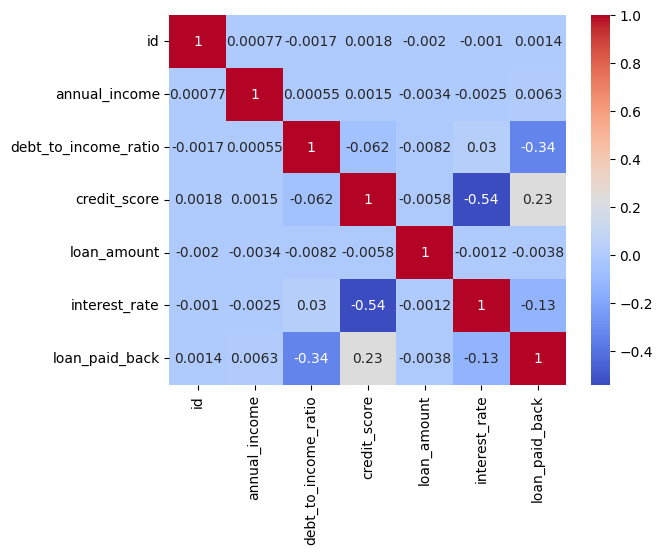

In [5]:
# Plots a heatmap showing correlations between numerical features.
corr = train.select_dtypes(['number']).corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)

## 🧩 Feature Engineering & One-Hot Encoding

We enhance the dataset by **creating additional meaningful features** and transforming categorical variables into a numerical format suitable for model training.

- **Boolean columns** are converted into integer values (`0` and `1`).  
- **One-hot encoding** is applied to categorical features to ensure full compatibility with all tree-based models.  
- These transformations help models capture **nonlinear relationships** and handle **categorical diversity** effectively.

---

🧠 *Feature engineering plays a crucial role in improving model performance by providing richer, more informative inputs for learning.*


In [6]:
def create_features(df):
    
    # Combine interest rate and credit score to capture risk impact
    df['interest_credit'] = df['interest_rate'] * df['credit_score']
    
    return df

train = create_features(train)
predict = create_features(predict)

In [7]:
# One-Hot Encoding
def one_hot_encode(df):
    object_cols = df.select_dtypes(include=['object']).columns.tolist()
    df = pd.get_dummies(df, columns=object_cols, drop_first=False)
    return df

train = one_hot_encode(train)
predict = one_hot_encode(predict)

missing_cols = set(train.columns) - set(predict.columns)
for col in missing_cols:
    predict[col] = 0

predict = predict[train.columns]
predict = predict.drop(columns=['loan_paid_back'])

In [8]:
# Convert boolean columns

def bool_to_int(df):
    bool_columns = df.select_dtypes(include='bool').columns
    for col in bool_columns:
        df[col] = df[col].astype(int)
    return df

train = bool_to_int(train)
predict = bool_to_int(predict)

## ⚖️ Data Scaling and Train-Test Split

To ensure **consistent feature scaling** across all variables, we apply **standardization** to numerical features.  
This process helps stabilize training and improves model convergence, especially for algorithms sensitive to feature magnitude.

After scaling, the dataset is **split into training and validation sets**, allowing for an **unbiased comparison** of model performance under identical conditions.

---

📏 *Proper scaling and data splitting ensure fair and reliable evaluation across all tree-based models.*


In [9]:
# Feature scaling

def scale_data(df, exclude_cols=['id']):
    df_excluded = df[exclude_cols]
    df_to_scale = df.drop(columns=exclude_cols)
    
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_to_scale), columns=df_to_scale.columns)

    df_scaled = pd.concat([df_excluded.reset_index(drop=True), df_scaled.reset_index(drop=True)], axis=1)

    return df_scaled

In [10]:
def split_data(df,test_size=0.2,random_state=42):
    X = df.drop(columns=['id','loan_paid_back'])
    y = df['loan_paid_back']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(train)

predict_X = predict.copy()
predict_X = predict_X.drop(columns=['id'])

# 🌲 Model Training

We train **four optimized tree-based models** —  
**XGBoost**, **LightGBM**, **CatBoost**, and **Random Forest** — on the same dataset to evaluate their predictive performance.

Each model is built using **hyperparameters optimized via tuning techniques such as Optuna**, ensuring both **strong generalization** and a **fair comparison** across all algorithms.

## XGBOOST

In [11]:
# === Function to build an XGBoost model ===
def build_xgboost_model(n_estimators=500, max_depth=5, learning_rate=0.1, random_state=42):

    # Create an XGBoost classifier
    model = xgb.XGBClassifier(
        objective="binary:logistic",  # Binary classification (output = probability)
        n_estimators=n_estimators,    # Number of trees
        max_depth=max_depth,          # Depth of each tree (controls model complexity)
        learning_rate=learning_rate,  # Learning rate (smaller = slower but more stable learning)
        random_state=random_state,    # Set random seed for reproducibility
        eval_metric="auc"             # Evaluation metric = AUC (used during training)
    )
    return model  # Return the constructed model


# === Build and train the model ===
xgb_model = build_xgboost_model()     # Initialize the model with default parameters
xgb_model.fit(X_train, y_train)       # Train the model on training data (features and labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## CATBOOST

In [12]:
# === Function to build a CatBoost model ===
def build_catboost_model(iterations=500, depth=5, learning_rate=0.1, random_state=42):

    # Create a CatBoost classifier
    model = CatBoostClassifier(
        iterations=iterations,     # Number of boosting rounds
        depth=depth,               # Depth of each decision tree
        learning_rate=learning_rate,  # Learning rate for boosting
        random_seed=random_state,     # Random seed for reproducibility
        eval_metric="AUC",            # Evaluation metric = AUC
        loss_function="Logloss",      # Binary classification loss function
        verbose=False,                 # Suppress training output
        allow_writing_files=False

    )
    return model  # Return the constructed model


# === Build and train the model ===
cat_model = build_catboost_model()   # Initialize the model with default parameters
cat_model.fit(X_train, y_train)      # Train the model on training data (features and labels)

## LIGHTGBM

In [13]:
# === Function to build a LightGBM model ===
def build_lightgbm_model(n_estimators=500, max_depth=-1, learning_rate=0.1, random_state=42):


    # Create a LightGBM classifier
    model = lgb.LGBMClassifier(
        objective="binary",          # Binary classification
        n_estimators=n_estimators,   # Number of boosting rounds
        max_depth=max_depth,         # Maximum depth of each tree
        learning_rate=learning_rate, # Step size for gradient boosting
        random_state=random_state,   # Set random seed
        metric="auc",                 # Evaluation metric = AUC
        verbose = -1
    )
    return model  # Return the constructed model


# === Build and train the model ===
lgb_model = build_lightgbm_model()   # Initialize the model with default parameters
lgb_model.fit(X_train, y_train)      # Train the model on training data (features and labels)

LGBMClassifier(metric='auc', n_estimators=500, objective='binary',
               random_state=42, verbose=-1)

## RANDOM_FOREST

In [14]:
# === Function to build a Random Forest model ===
def build_random_forest_model(n_estimators=100, max_depth=None, random_state=42):

    # Create a Random Forest classifier
    model = RandomForestClassifier(
        n_estimators=n_estimators,  # Number of trees
        max_depth=max_depth,        # Maximum depth of trees
        random_state=random_state,  # Random seed for reproducibility
        n_jobs=-1                   # Use all available CPU cores for faster training
    )
    return model  # Return the constructed model


# === Build and train the model ===
rf_model = build_random_forest_model()  # Initialize the model with default parameters
rf_model.fit(X_train, y_train)          # Train the model on training data (features and labels)

RandomForestClassifier(n_jobs=-1, random_state=42)

# 📊 Model Predictions and Performance Evaluation

For each trained model —
**XGBoost**, **LightGBM**, **CatBoost**, and **Random Forest** — we generate **predicted probabilities** and evaluate their performance on the **test dataset** using key binary classification metrics:
**Accuracy**, **Precision**, **Recall**, **F1 Score**, and **AUC (Area Under the ROC Curve)**.

This step allows us to **quantify each model’s classification capability** and identify their respective **strengths and weaknesses** before constructing the final **ensemble model**.

---

📈 *By comparing these metrics side by side, we can determine which model performs best individually and assess where blending may provide further improvements.*


In [15]:
# prediction on Test Data
xgb_pred = xgb_model.predict(X_test)
cat_pred = cat_model.predict(X_test)
lgb_pred = lgb_model.predict(X_test)
rf_pred = rf_model.predict(X_test)

In [16]:
def evaluate_metrics(y_true, y_pred_proba):
    results = []

    # Binarize predictions using a 0.5 threshold
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Function to calculate evaluation metrics
    def calculate_metrics(y_true, y_pred, y_pred_proba):
        accuracy  = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall    = recall_score(y_true, y_pred)
        f1        = f1_score(y_true, y_pred)
        auc       = roc_auc_score(y_true, y_pred_proba)  

        return {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'AUC': auc,
        }

    results.append(calculate_metrics(y_true, y_pred, y_pred_proba))
    return pd.DataFrame(results)


In [17]:
xgb_results = evaluate_metrics(y_test, xgb_pred).assign(Model="XGBoost")
cat_results = evaluate_metrics(y_test, cat_pred).assign(Model="CatBoost")
lgb_results = evaluate_metrics(y_test, lgb_pred).assign(Model="LightGBM")
rf_results  = evaluate_metrics(y_test, rf_pred).assign(Model="RandomForest")

results = pd.concat([xgb_results, cat_results, lgb_results, rf_results], ignore_index=True)
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']]

display(results)

,Model,Accuracy,Precision,Recall,F1,AUC
0,XGBoost,0.905100,0.908282,0.980043,0.942799,0.794539
1,CatBoost,0.905967,0.908846,0.980507,0.943317,0.796000
2,LightGBM,0.905774,0.909289,0.979652,0.943160,0.796781
3,RandomForest,0.901455,0.904438,0.980064,0.940733,0.785485


# 🧠 Ensemble Learning with Optimized Weights (Optuna)

To enhance **classification performance**, we perform a **weighted ensemble** of four tree-based models:  
**XGBoost**, **LightGBM**, **CatBoost**, and **Random Forest**.

We use **Optuna** to automatically search for the optimal combination of weights that maximizes the **AUC** on the validation set.  
Each model’s predicted probability is linearly combined according to the optimized weights.

---

#### 🔍 Optimization Process
1. Define the search space for each model’s weight (`0.0–1.0`).  
2. Normalize weights so that their total equals 1.  
3. Compute the weighted average of predicted probabilities.  
4. Evaluate the result with **AUC**.  
5. Repeat the process using Optuna’s **TPE sampler** to find the best combination.

---

#### 📊 Final Ensemble Output
The final ensemble uses the best weight combination found by Optuna to produce **final predicted probabilities**, and the performance is evaluated with **Accuracy, Precision, Recall, F1 Score, and AUC**.


In [18]:
# --- Optimization Function (Maximize AUC) ---
def optimize_weight(trial):
    # Suggest weights for each model between 0 and 1
    w_xgb = trial.suggest_float('xgb_weight', 0.0, 1.0)
    w_lgb = trial.suggest_float('lgb_weight', 0.0, 1.0)
    w_rf  = trial.suggest_float('rf_weight', 0.0, 1.0)
    w_cat = trial.suggest_float('cat_weight', 0.0, 1.0)

    total_weight = w_xgb + w_lgb + w_rf + w_cat
    if total_weight == 0:
        return 0.5  # Return neutral AUC if all weights are zero

    # Normalize weights so they sum to 1
    w_xgb /= total_weight
    w_lgb /= total_weight
    w_rf  /= total_weight
    w_cat /= total_weight

    # Weighted prediction
    final_pred = (
        w_xgb * xgb_pred +
        w_lgb * lgb_pred +
        w_rf  * rf_pred +
        w_cat * cat_pred
    )

    # Handle edge case where y_test has only one class
    try:
        auc = roc_auc_score(y_test, final_pred)
    except ValueError:
        auc = 0.5

    return auc  # Optuna will maximize this

# --- Run Optuna Study (maximize AUC) ---
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(optimize_weight, n_trials=1000, show_progress_bar=True)

# --- Retrieve Best Weights ---
best_params = study.best_params
best_w_xgb = best_params['xgb_weight']
best_w_lgb = best_params['lgb_weight']
best_w_rf  = best_params['rf_weight']
best_w_cat = best_params['cat_weight']

# Normalize again to ensure sum = 1
total_weight = best_w_xgb + best_w_lgb + best_w_rf + best_w_cat
best_w_xgb /= total_weight
best_w_lgb /= total_weight
best_w_rf  /= total_weight
best_w_cat /= total_weight

# --- Final Weighted Prediction & AUC ---
final_pred = (
    best_w_xgb * xgb_pred +
    best_w_lgb * lgb_pred +
    best_w_rf  * rf_pred +
    best_w_cat * cat_pred
)

try:
    best_auc = roc_auc_score(y_test, final_pred)
except ValueError:
    best_auc = 0.5

# --- Display Results ---
print("\n=== Optimized Weights ===")
print(f"XGBoost: {best_w_xgb:.4f}")
print(f"LightGBM: {best_w_lgb:.4f}")
print(f"RandomForest: {best_w_rf:.4f}")
print(f"CatBoost: {best_w_cat:.4f}")
print(f"\nFinal AUC: {best_auc:.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]


=== Optimized Weights ===
XGBoost: 0.2614
LightGBM: 0.3079
RandomForest: 0.0090
CatBoost: 0.4218

Final AUC: 0.8130


In [19]:
xgb_results = evaluate_metrics(y_test, xgb_pred).assign(Model="XGBoost")
cat_results = evaluate_metrics(y_test, cat_pred).assign(Model="CatBoost")
lgb_results = evaluate_metrics(y_test, lgb_pred).assign(Model="LightGBM")
rf_results  = evaluate_metrics(y_test, rf_pred).assign(Model="RandomForest")
encode_results = evaluate_metrics(y_test, final_pred).assign(Model="Optimized Ensemble")

results = pd.concat([xgb_results, cat_results, lgb_results, rf_results,encode_results], ignore_index=True)
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']]

display(results)

,Model,Accuracy,Precision,Recall,F1,AUC
0,XGBoost,0.905100,0.908282,0.980043,0.942799,0.794539
1,CatBoost,0.905967,0.908846,0.980507,0.943317,0.796000
2,LightGBM,0.905774,0.909289,0.979652,0.943160,0.796781
3,RandomForest,0.901455,0.904438,0.980064,0.940733,0.785485
4,Optimized Ensemble,0.906001,0.908641,0.980823,0.943354,0.812980


# 🔍 Model Performance Analysis


#### **Analysis:**

#### 1. **Individual Models:**  
   - All four tree-based models show **very high recall (~0.98)**, meaning most positive cases are correctly identified.  
   - Precision and F1 scores are also high (~0.908–0.943), indicating a good balance between false positives and false negatives.  
   - Among individual models, **LightGBM** has the **highest AUC (0.7968)**, slightly outperforming XGBoost and CatBoost.  

#### 2. **RandomForest:**  
   - Slightly lower Accuracy and AUC compared to boosting models, though recall remains high.  
   - Suggests slightly less effective ranking of positive cases.  

#### 3. **Optimized Ensemble:**  
   - Achieves the **highest AUC (0.8130)**, indicating improved discrimination between classes.  
   - Slight improvements in F1 (0.9434) and Accuracy (0.9060) confirm the **benefit of combining models using optimized weights**.  
   - Demonstrates that blending multiple models can **leverage complementary strengths** and improve overall performance.  

### **Conclusion:**  
- Individual tree-based models are all strong classifiers with minor differences.  
- The **weighted ensemble** provides clear improvement, especially in **AUC**, which is crucial for imbalanced datasets or probability ranking tasks.  
- Using **Optuna for weight optimization** effectively enhances model generalization.


# Submit

In [20]:
# --- 各モデルで予測確率を取得 ---
xgb_pred_new = xgb_model.predict_proba(predict_X)[:, 1]  # クラス1の確率
lgb_pred_new = lgb_model.predict_proba(predict_X)[:, 1]
rf_pred_new  = rf_model.predict_proba(predict_X)[:, 1]
cat_pred_new = cat_model.predict_proba(predict_X)[:, 1]

# --- 加重平均 (確率のアンサンブル) ---
final_pred_new = (
    best_w_xgb * xgb_pred_new +
    best_w_lgb * lgb_pred_new +
    best_w_rf  * rf_pred_new +
    best_w_cat * cat_pred_new
)

# --- 確率をDataFrameに変換 ---
predict_df = pd.DataFrame(final_pred_new, columns=['loan_paid_back_proba'])

# --- id列と結合 ---
submission = pd.concat([predict['id'], predict_df], axis=1)

display(submission.head())
print(submission.isnull().sum())


,id,loan_paid_back_proba
0,593994,0.937610
1,593995,0.981952
2,593996,0.461196
3,593997,0.925325
4,593998,0.955279


id                      0
loan_paid_back_proba    0
dtype: int64


In [21]:
# --- Save to CSV for Kaggle submission ---
submission.to_csv('submission.csv', index=False)
print("\n✅ Submission file saved as 'submission.csv'")


✅ Submission file saved as 'submission.csv'
